# PLAN: Make a n-gram model for making more names

- Read data from dataset and convert them to dataset X and y
- Create embedding
- Build the next two layers of the NN
- Construct train loop  
- Finding better hyperparameters
- Inference

In [1]:
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F

## Create Dataset

In [2]:
with open('names.txt') as f:
    data = f.read().split('\n')
print(len(data))
print(data[:10])

32033
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia', 'harper', 'evelyn']


In [3]:
characters = list(set([i for i in ''.join(data)]))
characters.insert(1, '.')
hmap = {}
for n in range(0,27):
    hmap[sorted(characters)[n]] = n
rev_hmap = {value:key for key,value in hmap.items()}
print(hmap)
print(rev_hmap)

{'.': 0, 'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26}
{0: '.', 1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z'}


In [4]:
n = 4
X, y = [], []

for word in data:
    w = '.' * n + word + '.' * n
    # print(w)
    for i in range(len(word)+n-2):
        temp = []
        for j in w[i:i+n]:
            temp.append(hmap[j])
        X.append(temp)
        y.append(hmap[w[i+n]])
        if w[i+n] == '.': break

# for i,j in zip(X,y):
#     print(i,j)
X = torch.tensor(X)   
y = torch.tensor(y)   

In [5]:
X, X.shape

(tensor([[ 0,  0,  0,  0],
         [ 0,  0,  0,  5],
         [ 0,  0,  5, 13],
         ...,
         [ 0, 26, 26, 25],
         [26, 26, 25, 26],
         [26, 25, 26, 24]]),
 torch.Size([228146, 4]))

# Creating Embedding Layer

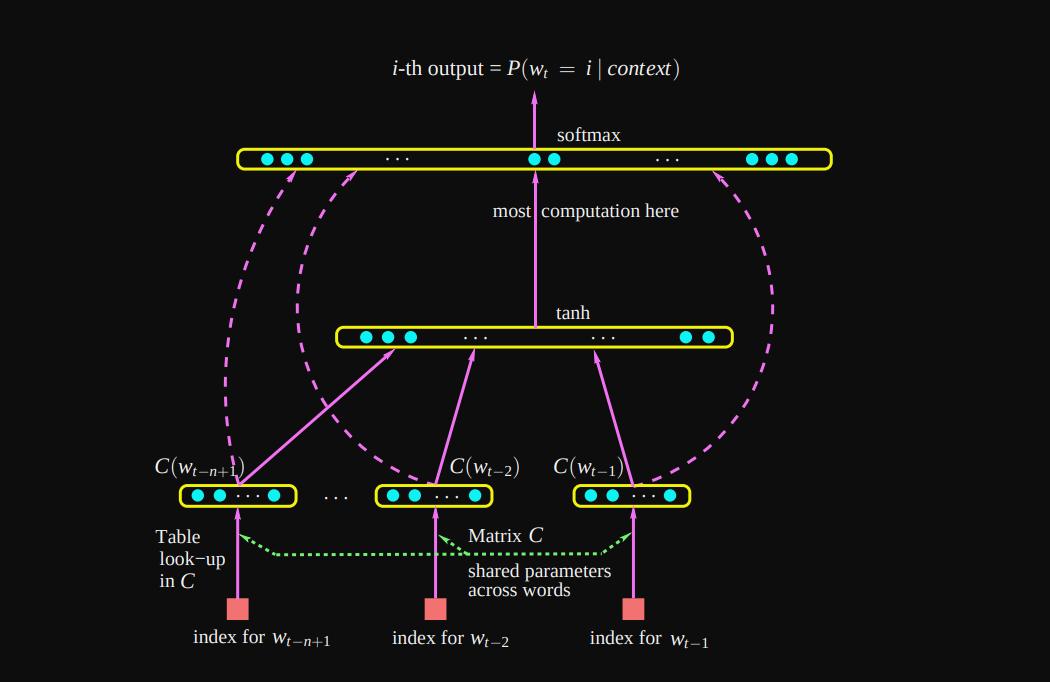

In [6]:
C = torch.randn((27,2)) # We embed 27 features(letters) into a 2 dimensional space. Will train over this later
emb = C[X]
emb.shape

torch.Size([228146, 4, 2])

In [7]:
C

tensor([[ 0.1600,  0.3777],
        [ 0.1136, -0.2247],
        [-0.3416, -0.7238],
        [ 0.5279, -0.9446],
        [ 1.3937, -0.7551],
        [-0.2734, -1.6819],
        [-1.6272,  0.7760],
        [-1.1405, -1.2254],
        [ 0.1876, -0.3966],
        [-1.4557,  1.0155],
        [-1.2023, -0.2085],
        [-1.6140, -0.8937],
        [-2.6290, -0.6631],
        [ 1.5587,  1.7965],
        [ 0.2788, -0.9953],
        [ 1.5141, -1.3305],
        [ 2.0363,  1.7410],
        [-1.2255,  2.0970],
        [ 0.7570,  0.9188],
        [-1.5146,  1.2623],
        [ 0.1923,  0.4662],
        [ 0.2519,  2.7950],
        [ 0.7031, -0.7745],
        [ 0.4226, -1.0383],
        [-0.8915, -0.2674],
        [-0.4280,  0.9105],
        [ 0.5039,  1.8396]])

# Neural Network Layers

In [8]:
h1 = 300
num_epoch = 10000
lr = 0.1

In [9]:
W1 = torch.randn(C[X].shape[1]*C[X].shape[2],h1)
b1 = torch.randn(h1)

W2 = torch.randn(h1,27)
b2 = torch.randn(27)

parameters = [C, W1, W2, b1, b2]

## Training the NN

In [10]:
for p in parameters:
    p.requires_grad = True

for i in range(num_epoch):
    
    batch = torch.randint(1,len(X),(64,))
    x = X[batch]
    y_ = y[batch]
    
    emb = C[x]
    A1 = torch.tanh(emb.view(-1, C[x].shape[1]*C[x].shape[2]) @ W1 + b1)
    logits = A1 @ W2 + b2
    loss = F.cross_entropy(logits, y_)
    

    for p in parameters:
        p.grad = None
    loss.backward()
    for p in parameters:
        p.data -= lr * p.grad
    
    if  i == 2000 or i == 5000:
        lr = lr/10
     

    if not i%1000: print(f'Epoch {i}: {loss.item():.4f}')

Epoch 0: 24.2087
Epoch 1000: 3.2726
Epoch 2000: 2.3351
Epoch 3000: 2.3180
Epoch 4000: 2.3772
Epoch 5000: 2.3600
Epoch 6000: 2.4360
Epoch 7000: 2.3161
Epoch 8000: 2.3619
Epoch 9000: 2.3273


In [11]:
# loss over entire dataset
emb = C[X]
A1 = torch.tanh(emb.view(-1, C[x].shape[1]*C[x].shape[2]) @ W1 + b1)
logits = A1 @ W2 + b2
loss = F.cross_entropy(logits, y)
loss.item()

2.437516450881958

## Inference

In [19]:
for i in range(10):
    char_index = torch.tensor([0 for i in range(n)])
    l = []
    while True:
        emb = C[char_index]
        A1 = torch.tanh(emb.view(-1, C[X].shape[1]*C[X].shape[2]) @ W1 + b1)
        logits = A1 @ W2 + b2
        cts = logits.exp()
        prob = cts/cts.sum(1, keepdim=True)
        ans = torch.multinomial(prob, num_samples=1, replacement=True)  
        l.append(rev_hmap[ans.item()])
        new = list(char_index)
        new.pop(0)
        new.append(ans)
        char_index = torch.tensor(new)

        if char_index[-1] == 0:
            print(''.join(l))
            break

aialansiya.
mayreynnl.
unmad.
waroh.
bemlo.
anilin.
camide.
samm.
muel.
sochanle.
